In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:90%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:11pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:10pt;padding:5px;}
table.dataframe{font-size:10px;}
</style>
"""))

<font size="6" color="red"><b>ch4. 머신러닝 모형 최적화</b></font>
# 1절. 변수 선택과 차원 축소
## 1-1 변수선택과 차원축소
- 종속변수에 영향을 주는 변수들을 찾아 학습에 사용할 독립변수의 수를 줄임 (어떻게 하면 score를 높일 수 있을지?)
- 과적합과 변수들 사이의 다중공선성(변수들간 강한 상관관계)을 줄일 수 있음
 * 회귀계수 해석이 어려워짐. 모델 예측력이 좋아도 해석력이 떨어짐(어떤 변수가 제일 큰 요인인지 잘), p값이나 유의성 검정이 왜곡될 수 있음
- 모형의 학습 시간을 줄일 수 있음
- 주성분분석, 상관분석, **분류모형의 feature_importance_, 예측 모형의 coef_**
- SelectKBest : 가장 높은 score에 따라 K개의 특징을 선택
## 1-2 주성분분석(PCA, Principal Component Anaysis)
- 주성분분석은 변수 선택 및 차원축소 방법(기존의 모든 변수를 조합하여 새로운 변수로 만듦)으로 널리 사용
- 주성분 분석은 상관관계가 있는 변수들을 선형결합해서 **분산이 극대화된 상관관계가 없는 새로운 변수(주성분)들로 축약**하는 것
- 주성분 분석은 사실 선형대수학이라기보다는 선형대수학의 활용적인 측면이 강하며 영상인식, 통계 데이터분석(주성분 찾기), 데이터 압축, 노이즈 제거 등 여러 분야에 사용
- 영상처리에서 많이 활용 : 여러 개의 영상 중 대표 이미지를 찾을 때 활용
- 다중공선성(Multicollinearity) 줄이는 것이 목표

In [2]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris_X, iris_y = iris.iloc[:, :-1], iris.species
iris_X.shape, iris_y.shape

((150, 4), (150,))

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # n_components: 주성분 개수
# pca.fit(iris_X)
# pca.transform(iris_X)
iris_pca = pca.fit_transform(iris_X)
iris_pca[:3] #뽑힌 주성분 2개

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943]])

In [7]:
import pandas as pd
# corr 확인하기 위해 배열 → DF
pd.DataFrame(iris_pca, columns=['pca1', 'pca2']).corr() #주성분끼리의 상관관계

,pca1,pca2
pca1,1.000000e+00,3.722081e-16
pca2,3.722081e-16,1.000000e+00


In [8]:
# 설명 분산: 각 주성분이 데이터 분산을 잘 표현하는지(정보량)
# 값이 클수록 더 중요한 주성분
pca.explained_variance_

array([4.22824171, 0.24267075])

In [9]:
# 설명 정도: 0~1 사이의 비율로 조정된 값
pca.explained_variance_ratio_
# 합이 1이 아니다! 변수를 줄이는 과정에서 손실

array([0.92461872, 0.05306648])

In [11]:
pca.components_
# 각 주성분의 계수 : 각 주성분이 원래 특성들과 어떤 관계가 있는지 나타내는 가중치
# array([[a1, b1, c2, d2], [a2, b2, c2, d2]])
# pca1 = a1*sepal_length + b1*sepal_width + c1*petal_length + d1*petal_width
# pca2 = a2*sepal_length + b2*sepal_width + c2*petal_length + d2*petal_width

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

In [12]:
iris_X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## 1-3 상관관계 확인
- 각 변수들끼리 상관관계를 확인하고 시각화해서 종속변수와 상관관계가 높은 변수들만 선택

In [14]:
import pandas as pd
#redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine = pd.read_csv('data/winequality-red.csv', delimiter=';')
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


cmap의 종류 : 
- https://jrc-park.tistory.com/155
- http://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
- http://seaborn.pydata.org/examples/many_pairwise_correlations.html

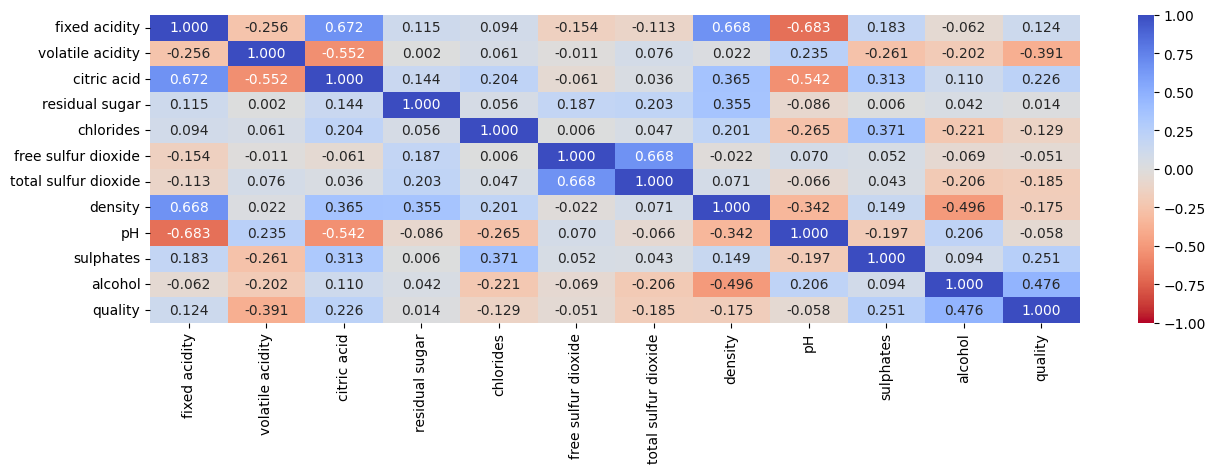

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,4))
corr = redwine.corr()
sns.heatmap(corr, annot=True, fmt='.3f', vmin=-1, vmax=1, cmap='coolwarm_r')
plt.show()

In [24]:
# mask 생성
import numpy as np
# np.tril(np.ones_like(corr), k=-1) #lower area에 삼각형 (대각선 제외)
mask = np.triu(np.ones_like(corr)) #upper area에 삼각형 (대각선 포함 (k=0))
mask

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

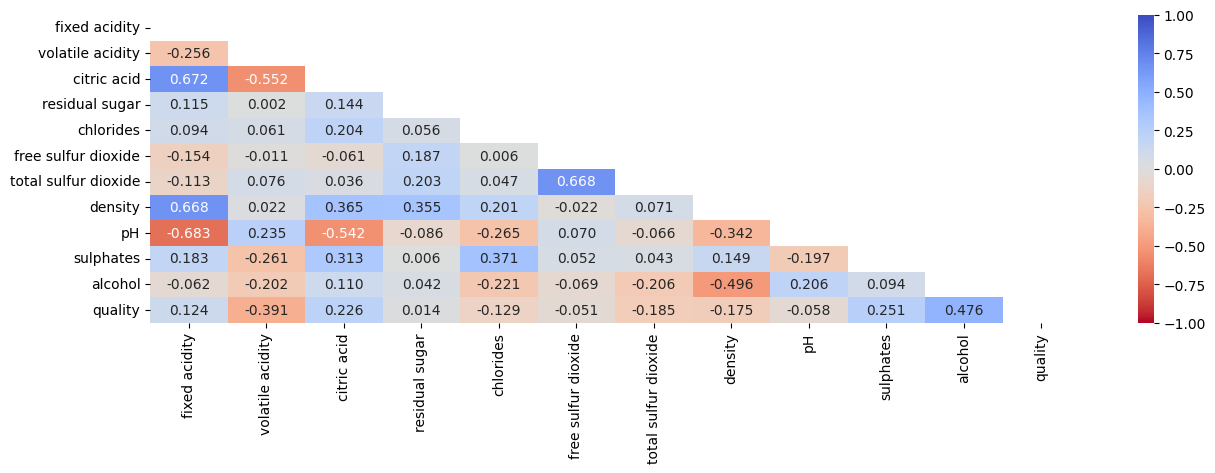

In [25]:
plt.figure(figsize=(15,4))
corr = redwine.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, fmt='.3f', vmin=-1, vmax=1, cmap='coolwarm_r', mask=mask)
plt.show()

## 1-4 분류 모형의 Feature Importances
- 분류모형의 **feature_importances_** 속성: 각 독립변수들이 종속변수에 영향을 주는 정도
- DecisionTreeClassifier, RnadomForestClassifier, GradientBoostingClassifier ... (tree 계열)
- LogisticRegression, SVC, MLPclassifier 등은 feature_importances_ 속성 없음

In [31]:
from sklearn.model_selection import train_test_split
X = redwine.iloc[:, :-1]#.values # np array로
y = redwine.iloc[:, -1]#.to_numpy()
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, stratify=y)
train_X.shape, test_X.shape, train_y.shape, test_y.shape, type(train_X) #학습할 데이터는 꼭 np array로 바꿔

((1119, 11), (480, 11), (1119,), (480,), pandas.core.frame.DataFrame)

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=10, random_state=10) # 트리 개수 10
rf_model.fit(train_X, train_y)

RandomForestClassifier(n_estimators=10, random_state=10)

In [33]:
 rf_model.score(test_X, test_y) # accuracy

0.6791666666666667

In [34]:
rf_model.feature_importances_ # 종속변수에 각 독립변수가 영향을 주는 정도 (합 1)

array([0.07469209, 0.09938282, 0.06850902, 0.0716863 , 0.0821784 ,
       0.07366436, 0.10871139, 0.09178841, 0.07340966, 0.09648092,
       0.15949663])

In [37]:
features = pd.DataFrame(
    np.c_[X.columns, rf_model.feature_importances_], 
    columns=['feature', 'importance']
)
features['importance'].sum()

1.0

In [42]:
features.sort_values(by='importance', ascending=False, inplace=True)
features.reset_index(drop=True, inplace=True)
features.set_index(drop=True, keys='feature')

,importance
feature,
alcohol,0.159497
total sulfur dioxide,0.108711
volatile acidity,0.099383
sulphates,0.096481
density,0.091788
chlorides,0.082178
fixed acidity,0.074692
free sulfur dioxide,0.073664
pH,0.07341


### feature_importances_를 이용한 변수 중요도 시각화

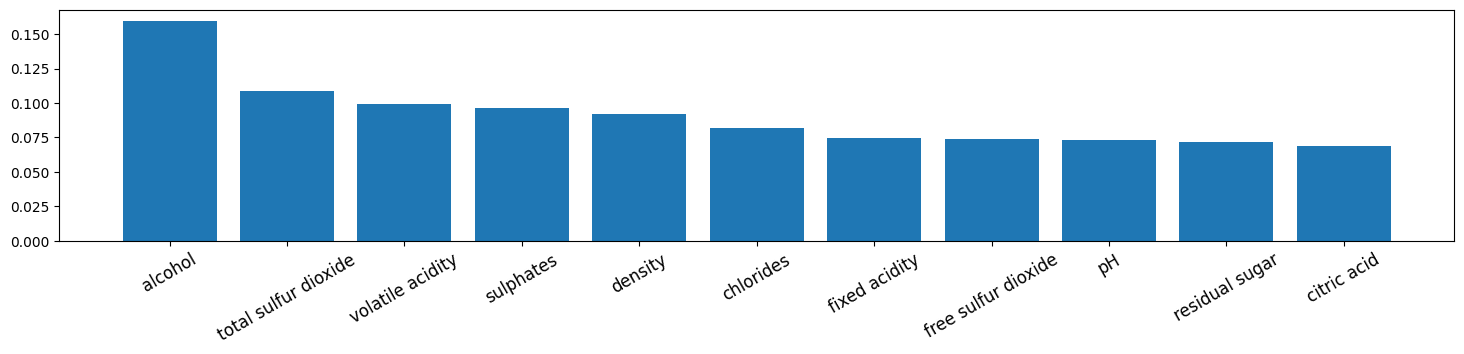

In [46]:
# features를 시각화
plt.figure(figsize=(18,3))
plt.bar(features.feature, features.importance)
plt.xticks(fontsize=12, rotation=30)
plt.show()

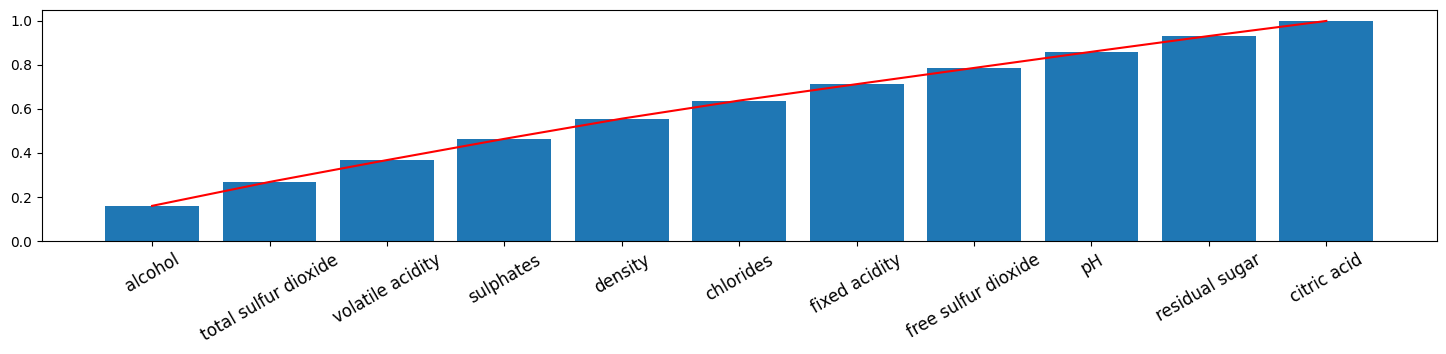

In [48]:
# 누적합을 이용한 시각화
y_stack = np.cumsum(features.importance)
plt.figure(figsize=(18,3))
plt.bar(features.feature, y_stack)
plt.plot(features.feature, y_stack, color='red')
plt.xticks(fontsize=12, rotation=30)
plt.show()

### RFE(Recursive Feature Elimination) 방식
- RFE를 이용하면 중요도에 따라 중요도가 낮은 변수부터 하나씩 제거해 나가면서 최종적으로 선택한 변수를 찾는다.

In [50]:
from sklearn.feature_selection import RFE
rfe_model = RFE(
    rf_model,
    n_features_to_select=5
)
rfe_model.fit(train_X, train_y)
rfe_model.get_support() # 선택된 변수는 True, 제거된 변수는 False

array([False,  True, False, False, False, False,  True,  True, False,
        True,  True])

In [52]:
feature_rfe = pd.DataFrame(np.c_[X.columns, rfe_model.get_support()], columns=['feature', 'selected'])
feature_rfe[feature_rfe.selected==True]
#feature_rfe

,feature,selected
1,volatile acidity,True
6,total sulfur dioxide,True
7,density,True
9,sulphates,True
10,alcohol,True


## 1-5 SelectKBest
- 가장 높은 score에 따라 k개 특정변수 선택

In [55]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, f_classif, chi2
# f_classif : ANNOVA F검정 - 독립변수가 연속형(그룹간 차이가 유의미한지)
# chi2 : 카이제곱통계량 검정 - 독립변수가 범주형(타깃변수도 범주형) 또는 양의 실수
X, y = load_iris(return_X_y=True, as_frame=False)
X.shape, y.shape
X_new = SelectKBest(f_classif, k=1).fit_transform(X, y)

In [58]:
load_iris()['feature_names'], X[:3], X_new[:3] # petal length (cm)

(['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2]]),
 array([[1.4],
        [1.4],
        [1.3]]))

# 2절. 파라미터 탐색
- 하이퍼파라미터(모델의 성능에 영향을 미칠 수 있는, 사용자가 직접 설정하는 파라미터)
- 어떤 파라미터를 사용하는 게 최적의 결과를 낼지 탐색
- sklearn 패키지의 하이퍼파라미터 튜닝 도구
    - validation_curve() : 단일 하이퍼파라미터 최적화 함수
    - GridSearchCV : 복수 하이퍼파라미터 최적화 클래스
## 2-1. validation_curve()
        - 모형, X, y, param_name(파라미터 이름), param_range(파라미터 값 list), 교차검증, scoring 기준

In [91]:
# 데이터
from sklearn.datasets import load_digits
digits = load_digits()
# digits.data : 1797*64 크기의 배열
# digits.target : 1797 크기의 배열(0~9중 하나)
# digits.images.shape: 1797*8*8 크기의 배열(이미지 형태)
X, y = digits.data, digits.target
X.shape, y.shape

((1797, 64), (1797,))

In [62]:
X[0].reshape(8,8)

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

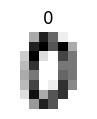

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(1,1))
plt.imshow(X[0].reshape(8,8), cmap='gray_r')
plt.axis('off')
plt.title(y[0])
plt.show()

In [66]:
from sklearn.svm import SVC
model = SVC(probability=True).fit(X, y) #기본 파라미터로 모형 생성

In [70]:
test_x = X[0].reshape(1,-1)
print('예측:', model.predict(test_x), '/ 실제:', y[0])

예측: [0] / 실제: 0


In [73]:
prob = model.predict_proba(test_x)[0]
classes = model.classes_
# print('분류:', classes)
# print('확률:', prob)
for c, p in zip(classes, prob):
    print('{}일 확률: {:.3f}%'.format(c, p*100))

0일 확률: 99.101%
1일 확률: 0.018%
2일 확률: 0.048%
3일 확률: 0.087%
4일 확률: 0.059%
5일 확률: 0.141%
6일 확률: 0.072%
7일 확률: 0.097%
8일 확률: 0.074%
9일 확률: 0.302%


In [74]:
# 하이퍼파라미터 탐색 전 score 값 (accuracy)
model.score(X, y)

0.996661101836394

In [75]:
# SVC() 모형의 최적 gamma value 탐색
param_range = np.logspace(-6, -1, 10)
param_range

array([1.00000000e-06, 3.59381366e-06, 1.29154967e-05, 4.64158883e-05,
       1.66810054e-04, 5.99484250e-04, 2.15443469e-03, 7.74263683e-03,
       2.78255940e-02, 1.00000000e-01])

In [92]:
%%time
from sklearn.model_selection import validation_curve
train_scores, test_scores = validation_curve(
    SVC(), # 예측 모형
    X, y, # 데이터
    param_name='gamma', # gamma가 크면 판별함수의 결정 경계가 복잡해짐 (경계선 굴곡의 민감도) - 너무 높으면 overfitting 위험
    param_range=param_range,
    cv=10, # 교차검증
    scoring='accuracy', # balanced_accuracy(데이터 불균형 고려한 정확도)
    n_jobs=-1, # -1: 모든 코어 사용
)

CPU times: total: 344 ms
Wall time: 10.5 s


In [77]:
test_scores

array([[0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.29608939, 0.19553073, 0.19553073],
       [0.67777778, 0.74444444, 0.7       , 0.66666667, 0.73333333,
        0.67222222, 0.72222222, 0.70949721, 0.67597765, 0.73743017],
       [0.87777778, 0.95      , 0.90555556, 0.86666667, 0.92222222,
        0.91666667, 0.96666667, 0.93854749, 0.83240223, 0.91061453],
       [0.92222222, 0.96666667, 0.95      , 0.91111111, 0.95      ,
        0.98333333, 0.97777778, 0.96648045, 0.87709497, 0.92178771],
       [0.93888889, 0.97222222, 0.93333333, 0.95      , 0.97222222,
        0.98888889, 0.98333333, 0.99441341, 0.91061453, 0.94413408],
       [0.95555556, 1.        , 0.93333333, 0.96666667, 0.98888889,
        0.98888889, 0.99444444, 0.99441341, 0.96089385, 0.96648045],
       [0.93333333, 0.98888889, 0.95555556, 0.96666667, 0.98333333,
        0.98888889, 0.99444444, 0.99441341, 0.97765363, 0.96648045],
       [0.77777778, 0.89444444, 0.7611111

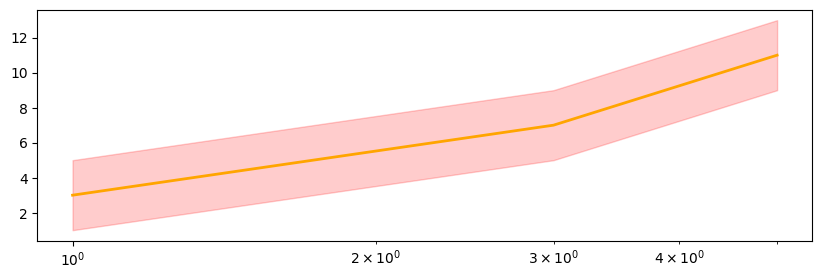

In [93]:
a = np.array([1, 3, 5]) # 10의1제곱, 10의3제곱, 10의5제곱
b = np.array([3, 7, 11]) # 3, 7, 11
plt.figure(figsize=(10,3))
plt.semilogx(a, b, color='orange', lw=2)
plt.fill_between(a, b-2, b+2, color='red', alpha=0.2)

In [94]:
train_scores_mean = np.mean(train_scores, axis=1) # train 평균
train_scores_std = np.std(train_scores, axis=1) # train 표준편차
test_scores_mean = test_scores.mean(axis=1) # test 평균
test_scores_std = test_scores.std(axis=1) # test 표준편차

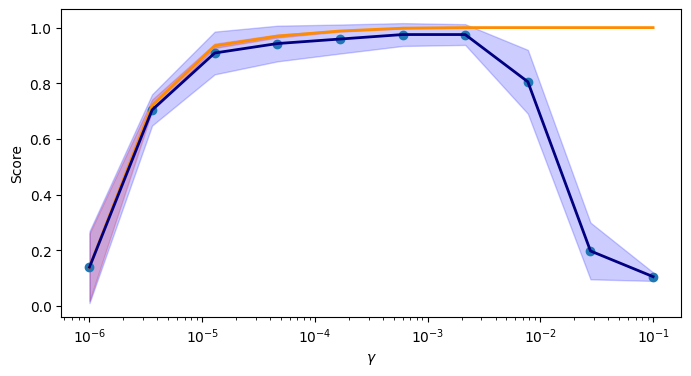

In [95]:
plt.figure(figsize=(8,4))
plt.semilogx(param_range, train_scores_mean, color='darkorange', lw=2)
plt.fill_between(
    param_range, 
    train_scores_mean-train_scores_std*2, 
    train_scores_mean+train_scores_std*2, 
    color='red', alpha=0.2
)
plt.semilogx(param_range, test_scores_mean, color='navy', lw=2)
plt.fill_between(
    param_range, 
    test_scores_mean-test_scores_std*2, 
    test_scores_mean+test_scores_std*2, 
    color='blue', alpha=0.2
)
plt.xlabel('$\gamma$')
plt.ylabel('Score')
plt.scatter(param_range, test_scores_mean)
plt.show()

In [89]:
test_scores_mean.argmax() # 6번째가 제일 크대

6

In [96]:
# 최적의 gamma
gamma = param_range[test_scores_mean.argmax()]
gamma

0.0021544346900318843

In [97]:
model = SVC(gamma=gamma).fit(X, y)

In [98]:
model.score(X, y)

1.0

## 2-2. GridSearchCV
- 복수 하이퍼파라미터 최적화 클래스
- 모형 클래스를 가지고 있음
- fit(), score(), predict(), predict_proba(), predict_log_proba(), transform(), decision_function() 메소드 구현

In [99]:
import pandas as pd
redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine_X = redwine.iloc[:,:-1]
redwine_y = redwine.iloc[:,-1]
redwine_X.shape, redwine_y.shape

((1599, 11), (1599,))

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC

In [101]:
%%time
# 가장 평가 점수가 높은 독립변수 ?개 선택
# SVC() 모형 최적의 C=? (, gamma=?, kernal=?)
selection = SelectKBest(k=1) # 가장 평가 점수가 높은 1(k)개를 찾음
svc = SVC(kernel='linear') # 직선으로 나누는 가장 단순한 decision_function을 생성
pipeline = Pipeline([('select', selection),('svc', svc)])
param_grid = dict(select__k = [5,6,7,8,9,10,11], 
                  svc__C = [0.1, 1, 10])
grid_search = GridSearchCV(pipeline, 
                           param_grid=param_grid, # 파라미터들 
                           cv=2, # 교차검증 k-fold cross validation
                           verbose=2, 
                           n_jobs=-1
                          )
grid_search.fit(redwine_X, redwine_y)

Fitting 2 folds for each of 21 candidates, totalling 42 fits
CPU times: total: 12.9 s
Wall time: 1min 26s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('select', SelectKBest(k=1)),
                                       ('svc', SVC(kernel='linear'))]),
             n_jobs=-1,
             param_grid={'select__k': [5, 6, 7, 8, 9, 10, 11],
                         'svc__C': [0.1, 1, 10]},
             verbose=2)

In [102]:
print(grid_search.best_estimator_) # 가장 높은 점수를 낸 파라미터 모형

Pipeline(steps=[('select', SelectKBest(k=9)),
                ('svc', SVC(C=1, kernel='linear'))])


In [103]:
print(grid_search.best_params_) # 최적의 파라미터 정보

{'select__k': 9, 'svc__C': 1}


In [104]:
model = grid_search.best_estimator_
model.predict(redwine_X)

array([5, 5, 5, ..., 6, 5, 6], dtype=int64)

In [105]:
# 최적 k값과 c값의 model
model.score(redwine_X, redwine_y)

0.5872420262664165

In [107]:
# 기본 SVC model
def_model = SVC().fit(redwine_X, redwine_y)
def_model.score(redwine_X, redwine_y)

0.5103189493433395

# 3절. 자료 불균형 처리
- 단순 오버/언더 샘플링
- 단, 단순 오버샘플링 시 소스의 데이터를 복사하면 그 데이터들에 의해 과적합 생길 수 있음
- SMOTE 라이브러리를 이용한 오버샘플링
## 3-1. SMOTE를 이용한 오버샘플링

In [110]:
# 데이터 99% : 1%
from sklearn.datasets import make_classification
X, y = make_classification(n_samples = 10000, #표본 수
                           n_features=10, #독립변수 개수
                           n_informative=5, #종속변수에 영향을 주는 개수
                           n_redundant=0,
                           n_clusters_per_class=1, #클래스당 서브클러스터 수
                           n_classes=2,
                           weights=[0.99, 0.01], #각 클래스에 할당된 표본 확률
                           random_state=42
                          )
X.shape, y.shape, y.sum()

((10000, 10), (10000,), 140)

In [111]:
# train-test set 분리 → SMOTE(train 데이터) → 모델 fit(train 데이터) → score(test 데이터)
# train-test set 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.3,
                                                   stratify=y,
                                                   random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7000, 10), (7000,), (3000, 10), (3000,))

In [114]:
print(y_train.mean()) # 1이 1.4%
pd.Series(y_train).value_counts()

0.014


0    6902
1      98
dtype: int64

In [115]:
# SMOTE(train 데이터)
# pip install imbalanced-learn==0.10.1
from imblearn.over_sampling import SMOTE
# sm = SMOTE(sampling_strategy={0:6902, 1:3000})
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [116]:
pd.Series(y_resampled).value_counts()

0    6902
1    6902
dtype: int64

## 3-2. 가중치 제어 모형
- 자료 불균형 처리의 또 다른 방법
- 데이터에 따른 가중치를 모델에 부여하는 방법

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight={0:1, 1:1.5}, # 가중치 부여(비율이 아니라 가산점으로 이해)
    random_state=42
)
rf_model.fit(X_train, y_train)

# 4절. 앙상블 모형
- 목적: 여러 개 분류 모델을 하나의 통합 분류모델로 연결하여 개별 분류모델보다 더 좋은 성능 달성
- 방법
    - 배깅(bagging): 병렬 작업 - 분류를 잘하는 모델에 가중치 (ex. RandomForest)
    - 부스팅(boosting): 순차 작업 - 분류가 안 된 데이터에 가중치 (ex. XGBoost, LGBM, AdaBoost) - 불균형데이터에도 효과적
    - 투표(voting): 여러 개 모델의 다수결 투표

cf. 배깅 알고리즘 사용 시, 복원추출 0.632규칙

In [118]:
np.random.choice(100, 100, replace=True) # 복원추출로 100 미만의 수 100개 추출

array([14, 85, 27,  4, 30, 68, 73, 41,  6, 41, 69, 24,  1,  3, 97, 64, 20,
       58, 38, 48, 66,  5, 42, 50, 75,  8, 34, 35, 96, 43, 31, 54, 87, 49,
       98, 52, 37, 87, 34, 29, 91, 38, 97, 84, 22,  3, 97, 37, 14, 62, 31,
       94, 21, 60, 17, 93, 43, 48, 98, 18, 18,  0, 86, 41, 23, 11, 52, 40,
       31, 30, 20, 76, 98, 19, 41, 48, 64, 53, 14,  8, 67, 21,  3, 13, 82,
       13, 39,  8, 76, 48, 31, 20, 60, 86, 35, 23,  2, 39, 62, 35])

In [174]:
len(set(np.random.choice(10, 10, replace=True))) # 10 미만의 수 10개 복원추출할 경우 뽑히는 수의 개수

6

In [175]:
len(set(np.random.choice(1000, 1000, replace=True)))

637

In [187]:
# n 미만의 수 n개 복원추출할 경우의 데이터 퍼센트 → n이 커질수록 63.2%로 수렴
n = 1000000
len(set(np.random.choice(n, n, replace=True)))/n

0.632166

In [188]:
# 데이터
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=10000,
    n_features=10,
    n_informative=5,
    n_redundant=0,
    n_clusters_per_class=1,
    n_classes=2,
    weights=[0.9, 0.1],
    random_state=42
)

In [189]:
train_X, test_X, train_y, test_y = train_test_split(
    X, y, 
    test_size=0.3,
    stratify=y,
    random_state=42
)
sm = SMOTE()
resampled_X, resampled_y = sm.fit_resample(train_X, train_y)
resampled_X.shape, resampled_y.shape

((12556, 10), (12556,))

In [192]:
from sklearn.metrics import precision_score, recall_score, f1_score
def model_measure(model, train_X=resampled_X, train_y=resampled_y, test_X=test_X, test_y=test_y):
    model.fit(train_X, train_y)
    accuracy = model.score(test_X, test_y)
    hat_y = model.predict(test_X)
    precision = precision_score(test_y, hat_y)
    recall = recall_score(test_y, hat_y)
    f1 = f1_score(test_y, hat_y)
    print(f"accuracy: {accuracy:.4f}, precision: {precision:.4f}, recall: {recall:.4f}, f1: {f1:.4f}")

## 4-1. 배깅
- RandomForestClassifier, BaggingClassifier

In [193]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)
model_measure(model)

accuracy: 0.9823, precision: 0.9295, recall: 0.8964, f1: 0.9127


In [194]:
from sklearn.ensemble import BaggingClassifier
model_measure(BaggingClassifier(n_estimators=100, bootstrap=True)) # bootstrap : 복원추출

accuracy: 0.9763, precision: 0.8814, recall: 0.8900, f1: 0.8857


## 4-2. 부스팅
- AdaBoost, XGBoost, LightGBM, CatBoost, GradientBoost

In [195]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [196]:
model_measure(AdaBoostClassifier())

accuracy: 0.9553, precision: 0.7238, recall: 0.9159, f1: 0.8086


In [197]:
model_measure(XGBClassifier())

accuracy: 0.9880, precision: 0.9659, recall: 0.9159, f1: 0.9402


In [200]:
model_measure(LGBMClassifier(force_col_wise=True))

[LightGBM] [Info] Number of positive: 6278, number of negative: 6278
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 12556, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
accuracy: 0.9870, precision: 0.9592, recall: 0.9126, f1: 0.9353


In [201]:
model_measure(CatBoostClassifier())

Learning rate set to 0.030349
0:	learn: 0.6503528	total: 142ms	remaining: 2m 22s
1:	learn: 0.6120004	total: 148ms	remaining: 1m 13s
2:	learn: 0.5758247	total: 154ms	remaining: 51s
3:	learn: 0.5384115	total: 159ms	remaining: 39.7s
4:	learn: 0.5074178	total: 165ms	remaining: 32.9s
5:	learn: 0.4729847	total: 171ms	remaining: 28.3s
6:	learn: 0.4451284	total: 177ms	remaining: 25.1s
7:	learn: 0.4221355	total: 182ms	remaining: 22.6s
8:	learn: 0.3975840	total: 188ms	remaining: 20.7s
9:	learn: 0.3792959	total: 194ms	remaining: 19.2s
10:	learn: 0.3600437	total: 201ms	remaining: 18.1s
11:	learn: 0.3421581	total: 208ms	remaining: 17.1s
12:	learn: 0.3265093	total: 215ms	remaining: 16.3s
13:	learn: 0.3134965	total: 221ms	remaining: 15.6s
14:	learn: 0.2993803	total: 227ms	remaining: 14.9s
15:	learn: 0.2857094	total: 234ms	remaining: 14.4s
16:	learn: 0.2735693	total: 240ms	remaining: 13.9s
17:	learn: 0.2633853	total: 246ms	remaining: 13.4s
18:	learn: 0.2539151	total: 252ms	remaining: 13s
19:	learn: 0.

175:	learn: 0.0591323	total: 1.24s	remaining: 5.81s
176:	learn: 0.0588496	total: 1.25s	remaining: 5.8s
177:	learn: 0.0586519	total: 1.27s	remaining: 5.85s
178:	learn: 0.0584284	total: 1.28s	remaining: 5.86s
179:	learn: 0.0581143	total: 1.28s	remaining: 5.85s
180:	learn: 0.0579288	total: 1.29s	remaining: 5.83s
181:	learn: 0.0576409	total: 1.29s	remaining: 5.82s
182:	learn: 0.0574915	total: 1.3s	remaining: 5.81s
183:	learn: 0.0572341	total: 1.31s	remaining: 5.82s
184:	learn: 0.0571458	total: 1.32s	remaining: 5.81s
185:	learn: 0.0568671	total: 1.32s	remaining: 5.8s
186:	learn: 0.0566874	total: 1.33s	remaining: 5.79s
187:	learn: 0.0564575	total: 1.34s	remaining: 5.78s
188:	learn: 0.0563403	total: 1.34s	remaining: 5.77s
189:	learn: 0.0560550	total: 1.35s	remaining: 5.76s
190:	learn: 0.0557373	total: 1.36s	remaining: 5.75s
191:	learn: 0.0554167	total: 1.36s	remaining: 5.74s
192:	learn: 0.0552733	total: 1.37s	remaining: 5.73s
193:	learn: 0.0550808	total: 1.38s	remaining: 5.73s
194:	learn: 0.0

362:	learn: 0.0324995	total: 2.47s	remaining: 4.33s
363:	learn: 0.0323594	total: 2.47s	remaining: 4.32s
364:	learn: 0.0322850	total: 2.48s	remaining: 4.32s
365:	learn: 0.0321792	total: 2.49s	remaining: 4.31s
366:	learn: 0.0321218	total: 2.49s	remaining: 4.3s
367:	learn: 0.0320256	total: 2.5s	remaining: 4.3s
368:	learn: 0.0319099	total: 2.51s	remaining: 4.29s
369:	learn: 0.0318291	total: 2.52s	remaining: 4.28s
370:	learn: 0.0317272	total: 2.52s	remaining: 4.28s
371:	learn: 0.0316741	total: 2.53s	remaining: 4.27s
372:	learn: 0.0315874	total: 2.54s	remaining: 4.26s
373:	learn: 0.0315320	total: 2.54s	remaining: 4.26s
374:	learn: 0.0314541	total: 2.55s	remaining: 4.25s
375:	learn: 0.0312951	total: 2.56s	remaining: 4.24s
376:	learn: 0.0312166	total: 2.56s	remaining: 4.23s
377:	learn: 0.0311665	total: 2.57s	remaining: 4.23s
378:	learn: 0.0310613	total: 2.57s	remaining: 4.22s
379:	learn: 0.0310063	total: 2.58s	remaining: 4.21s
380:	learn: 0.0308221	total: 2.59s	remaining: 4.2s
381:	learn: 0.03

551:	learn: 0.0194371	total: 3.69s	remaining: 2.99s
552:	learn: 0.0193909	total: 3.69s	remaining: 2.98s
553:	learn: 0.0193489	total: 3.7s	remaining: 2.98s
554:	learn: 0.0193217	total: 3.71s	remaining: 2.97s
555:	learn: 0.0192407	total: 3.71s	remaining: 2.96s
556:	learn: 0.0192151	total: 3.72s	remaining: 2.96s
557:	learn: 0.0191898	total: 3.73s	remaining: 2.95s
558:	learn: 0.0191493	total: 3.73s	remaining: 2.94s
559:	learn: 0.0191046	total: 3.74s	remaining: 2.94s
560:	learn: 0.0190713	total: 3.75s	remaining: 2.93s
561:	learn: 0.0190027	total: 3.75s	remaining: 2.92s
562:	learn: 0.0189767	total: 3.76s	remaining: 2.92s
563:	learn: 0.0188997	total: 3.77s	remaining: 2.91s
564:	learn: 0.0188519	total: 3.77s	remaining: 2.9s
565:	learn: 0.0188032	total: 3.78s	remaining: 2.9s
566:	learn: 0.0187319	total: 3.78s	remaining: 2.89s
567:	learn: 0.0186617	total: 3.79s	remaining: 2.88s
568:	learn: 0.0186440	total: 3.79s	remaining: 2.88s
569:	learn: 0.0185740	total: 3.8s	remaining: 2.87s
570:	learn: 0.01

741:	learn: 0.0125627	total: 4.92s	remaining: 1.71s
742:	learn: 0.0125397	total: 4.93s	remaining: 1.71s
743:	learn: 0.0125146	total: 4.94s	remaining: 1.7s
744:	learn: 0.0124893	total: 4.94s	remaining: 1.69s
745:	learn: 0.0124692	total: 4.95s	remaining: 1.69s
746:	learn: 0.0124341	total: 4.96s	remaining: 1.68s
747:	learn: 0.0123971	total: 4.96s	remaining: 1.67s
748:	learn: 0.0123756	total: 4.97s	remaining: 1.67s
749:	learn: 0.0123434	total: 4.98s	remaining: 1.66s
750:	learn: 0.0123164	total: 4.98s	remaining: 1.65s
751:	learn: 0.0122948	total: 4.99s	remaining: 1.65s
752:	learn: 0.0122639	total: 5s	remaining: 1.64s
753:	learn: 0.0122500	total: 5s	remaining: 1.63s
754:	learn: 0.0122128	total: 5.01s	remaining: 1.63s
755:	learn: 0.0121943	total: 5.02s	remaining: 1.62s
756:	learn: 0.0121770	total: 5.02s	remaining: 1.61s
757:	learn: 0.0121532	total: 5.03s	remaining: 1.61s
758:	learn: 0.0120965	total: 5.04s	remaining: 1.6s
759:	learn: 0.0120709	total: 5.04s	remaining: 1.59s
760:	learn: 0.012018

903:	learn: 0.0089330	total: 5.96s	remaining: 633ms
904:	learn: 0.0089194	total: 5.97s	remaining: 627ms
905:	learn: 0.0089169	total: 5.97s	remaining: 620ms
906:	learn: 0.0088918	total: 5.98s	remaining: 613ms
907:	learn: 0.0088918	total: 5.99s	remaining: 607ms
908:	learn: 0.0088851	total: 5.99s	remaining: 600ms
909:	learn: 0.0088591	total: 6s	remaining: 593ms
910:	learn: 0.0088456	total: 6s	remaining: 587ms
911:	learn: 0.0088385	total: 6.01s	remaining: 580ms
912:	learn: 0.0088149	total: 6.02s	remaining: 573ms
913:	learn: 0.0087850	total: 6.02s	remaining: 567ms
914:	learn: 0.0087754	total: 6.03s	remaining: 560ms
915:	learn: 0.0087638	total: 6.04s	remaining: 554ms
916:	learn: 0.0087336	total: 6.04s	remaining: 547ms
917:	learn: 0.0087174	total: 6.05s	remaining: 540ms
918:	learn: 0.0086934	total: 6.05s	remaining: 534ms
919:	learn: 0.0086649	total: 6.06s	remaining: 527ms
920:	learn: 0.0086577	total: 6.07s	remaining: 520ms
921:	learn: 0.0086356	total: 6.07s	remaining: 514ms
922:	learn: 0.0086